# 📚 Import Required Libraries

In [1]:
import os
import copy
import torch
import pickle
import pathlib
import logging
import numpy as np
import torchvision
import torch.nn as nn
from tqdm.auto import tqdm
from itertools import cycle
import torch.optim as optim
from google.colab import files
from google.colab import drive
import torch.nn.functional as F
from types import SimpleNamespace
from IPython.display import display
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

# 🚀 train a conditional VAE on all 10 MNIST classes.

## Mount Google Drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## Configuration

In [ ]:
# create a main project folder in Google Drive
gdrive_project_folder = "/content/drive/MyDrive/Colab_Selective_Amnesia"
output_folder_in_drive = os.path.join(gdrive_project_folder, "cvae_mnist_output")
os.makedirs(output_folder_in_drive, exist_ok=True)

config = SimpleNamespace(
    # Training parameters
    data_path="./dataset",
    batch_size=256,
    n_iters=100000, # The paper uses 100k iterations
    log_freq=5000,
    n_vis_samples=100,
    lr=0.0001,

    # Model parameters
    dataset="MNIST",
    x_dim=784,
    h_dim1=512,
    h_dim2=256,
    z_dim=8,

    output_dir=output_folder_in_drive,
)

# Create directories for logs and checkpoints
config.log_dir = os.path.join(config.output_dir, "logs")
config.ckpt_dir = os.path.join(config.output_dir, "checkpoints")
os.makedirs(config.log_dir, exist_ok=True)
os.makedirs(config.ckpt_dir, exist_ok=True)

## Logging Setup

In [ ]:
handler = logging.StreamHandler()
formatter = logging.Formatter("%(levelname)s - %(asctime)s - %(message)s")
handler.setFormatter(formatter)
logger = logging.getLogger()
if logger.hasHandlers():
    logger.handlers.clear()
logger.addHandler(handler)
logger.setLevel(logging.INFO)

## Model

In [11]:
class OneHotCVAE(nn.Module):
    """
    Conditional VAE with one-hot encoding for the condition.
    """
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim, class_size=10):
        super(OneHotCVAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(x_dim + class_size, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)

        # Decoder
        self.fc4 = nn.Linear(z_dim + class_size, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x, c):
        inputs = torch.cat([x, c], dim=1)
        h = F.relu(self.fc1(inputs))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h)

    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # reparameterization trick

    def decoder(self, z, c):
        inputs = torch.cat([z, c], dim=1)
        h = F.relu(self.fc4(inputs))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h))

    def forward(self, x, c):
        mu, log_var = self.encoder(x.view(-1, config.x_dim), c)
        z = self.sampling(mu, log_var)
        recon_x = self.decoder(z, c)
        return recon_x, mu, log_var

## Loss Function Definitions

In [ ]:
def loss_function(recon_x, x, mu, log_var):
    """
    Calculates the VAE loss
    """
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, config.x_dim), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

## Training, Testing, and Sampling Functions

In [ ]:
def train():
    """The main training loop."""

    vae.train()
    train_loss = 0

    logging.info("Starting training...")

    for step in range(1, config.n_iters + 1):
        data, label = next(train_iter)
        label_one_hot = F.one_hot(label, 10).float()

        data = data.to(device)
        label_one_hot = label_one_hot.to(device)

        optimizer.zero_grad()
        recon_batch, mu, log_var = vae(data, label_one_hot)
        loss = loss_function(recon_batch, data, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if step % config.log_freq == 0:
            avg_train_loss = train_loss / (config.log_freq * config.batch_size)
            avg_test_loss = test()
            logging.info(f'Train Step: {step}/{config.n_iters} ({100. * step / config.n_iters:.0f}%)\t'
                         f'Avg Train Loss: {avg_train_loss:.4f}\t'
                         f'Avg Test Loss: {avg_test_loss:.4f}')
            sample(step)
            train_loss = 0
            vae.train() # Set back to training mode after sampling/testing

def test():
    """Evaluates the model on the test dataset."""

    vae.eval()
    test_loss = 0

    with torch.no_grad():
        for data, label in test_loader:
            label_one_hot = F.one_hot(label, 10).float()
            data = data.to(device)
            label_one_hot = label_one_hot.to(device)
            recon, mu, log_var = vae(data, label_one_hot)
            test_loss += loss_function(recon, data, mu, log_var).item()

    avg_test_loss = test_loss / len(test_loader.dataset)
    return avg_test_loss

def sample(step):
    """Generates and saves a grid of images from the model."""

    vae.eval()

    with torch.no_grad():
        # Create a fixed noise vector and labels for consistent visualization
        z = torch.randn((config.n_vis_samples, config.z_dim)).to(device)
        c_labels = torch.arange(10).repeat_interleave(config.n_vis_samples // 10)
        c_one_hot = F.one_hot(c_labels, 10).float().to(device)

        out = vae.decoder(z, c_one_hot).view(-1, 1, 28, 28)

        grid = make_grid(out, nrow=config.n_vis_samples // 10)
        save_path = os.path.join(config.log_dir, f"sample_step_{step}.png")
        save_image(grid, save_path)
        logging.info(f"Saved sample image to {save_path}")

## Main Execution

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f"Using device: {device}")

# Load MNIST
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root=config.data_path, train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root=config.data_path, train=False, transform=transform, download=True)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=config.batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=config.batch_size, shuffle=False)

# create an infinite iterator over the training data
train_iter = cycle(train_loader)

# Build Model
vae = OneHotCVAE(x_dim=config.x_dim, h_dim1=config.h_dim1, h_dim2=config.h_dim2, z_dim=config.z_dim).to(device)

optimizer = optim.Adam(vae.parameters(), lr=config.lr)

# Start Training
train()

# Save the final model and config
final_ckpt_path = os.path.join(config.ckpt_dir, "cvae_mnist_final.pt")
torch.save({
    "model_state_dict": vae.state_dict(),
    "config": config
}, final_ckpt_path)
logging.info(f"Training complete. Final model saved to {final_ckpt_path}")

# You can uncomment the line below to automatically download the final model
# files.download(final_ckpt_path)

INFO - 2025-08-03 09:31:05,927 - Using device: cpu
INFO - 2025-08-03 09:31:06,021 - Starting training...
INFO - 2025-08-03 09:35:07,863 - Train Step: 5000/100000 (5%)	Avg Train Loss: 140.4244	Avg Test Loss: 114.4602
INFO - 2025-08-03 09:35:07,897 - Saved sample image to /content/drive/MyDrive/Colab_Selective_Amnesia/cvae_mnist_output/logs/sample_step_5000.png
INFO - 2025-08-03 09:39:00,580 - Train Step: 10000/100000 (10%)	Avg Train Loss: 110.9415	Avg Test Loss: 107.1669
INFO - 2025-08-03 09:39:00,896 - Saved sample image to /content/drive/MyDrive/Colab_Selective_Amnesia/cvae_mnist_output/logs/sample_step_10000.png
INFO - 2025-08-03 09:42:55,707 - Train Step: 15000/100000 (15%)	Avg Train Loss: 105.9545	Avg Test Loss: 104.2581
INFO - 2025-08-03 09:42:55,997 - Saved sample image to /content/drive/MyDrive/Colab_Selective_Amnesia/cvae_mnist_output/logs/sample_step_15000.png
INFO - 2025-08-03 09:46:54,774 - Train Step: 20000/100000 (20%)	Avg Train Loss: 103.2871	Avg Test Loss: 102.4340
INFO 

# 🧮 Calculate Fisher Information Matrix (FIM)

## Configuration

In [ ]:
fim_config = SimpleNamespace(

    ckpt_path=os.path.join(output_folder_in_drive, "checkpoints/cvae_mnist_final.pt"),

    n_fim_samples=50000, # Number of samples to use for FIM calculation

    batch_size=256,

    output_dir=output_folder_in_drive,
)

## FIM Calculation Function

In [ ]:
def calculate_and_save_fim(model, device, config):
    """Calculates and saves the diagonal of the Fisher Information Matrix."""

    fisher_dict = {}

    for name, param in model.named_parameters():
        if param.requires_grad:
            fisher_dict[name] = torch.zeros_like(param.data)

    # Set the model to evaluation mode for generating samples
    model.eval()

    logging.info(f"Calculating Fisher Matrix with {config.n_fim_samples} samples...")

    pbar = tqdm(total=config.n_fim_samples)

    num_processed = 0

    while num_processed < config.n_fim_samples:
        # Determine batch size for this iteration
        current_batch_size = min(config.batch_size, config.n_fim_samples - num_processed)

        # Generate a batch of samples from the model by sampling from the trained generator itself.
        with torch.no_grad():
            z = torch.randn(current_batch_size, model.fc31.out_features).to(device)
            c_labels = torch.randint(0, 10, (current_batch_size,)).to(device)
            c_one_hot = F.one_hot(c_labels, 10).float()
            generated_samples = model.decoder(z, c_one_hot)

        # Set model to train mode to enable gradient calculation and then Calculate gradients for the batch
        model.train()
        model.zero_grad()

        recon_batch, mu, log_var = model(generated_samples, c_one_hot)

        # average the loss over the batch for the backward pass
        loss = loss_function(recon_batch, generated_samples, mu, log_var) / current_batch_size
        loss.backward()

        # Accumulate the squared gradients
        for name, param in model.named_parameters():
            if param.grad is not None:
                # The multiplication by current_batch_size is to correct for the division in the loss
                fisher_dict[name] += param.grad.data.pow(2) * current_batch_size

        num_processed += current_batch_size
        pbar.update(current_batch_size)

    pbar.close()

    # Average the FIM over all samples
    for name in fisher_dict:
        fisher_dict[name] /= config.n_fim_samples

    # Save the calculated FIM
    fim_save_path = os.path.join(config.output_dir, 'fisher_dict.pkl')
    with open(fim_save_path, 'wb') as f:
        pickle.dump(fisher_dict, f)

    logging.info(f"Fisher Matrix calculation complete. Saved to {fim_save_path}")
    return fim_save_path

## Main Execution

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f"Using device: {device}")


if not os.path.exists(fim_config.ckpt_path):
    logging.error(f"Checkpoint not found at {fim_config.ckpt_path}. Please run the first training script.")

else:
    checkpoint = torch.load(fim_config.ckpt_path, map_location=device, weights_only=False)
    config_from_ckpt = checkpoint['config']

    # Build the model using the configuration from the checkpoint
    vae = OneHotCVAE(
        x_dim=config_from_ckpt.x_dim,
        h_dim1=config_from_ckpt.h_dim1,
        h_dim2=config_from_ckpt.h_dim2,
        z_dim=config_from_ckpt.z_dim
    ).to(device)

    # Load the trained weights into the model
    vae.load_state_dict(checkpoint['model_state_dict'])
    logging.info(f"Successfully loaded pre-trained model from {fim_config.ckpt_path}")

    calculate_and_save_fim(vae, device, fim_config)

INFO - 2025-08-03 09:41:48,403 - Using device: cuda
INFO - 2025-08-03 09:41:48,427 - Successfully loaded pre-trained model from /content/drive/MyDrive/Colab_Selective_Amnesia/cvae_mnist_output/checkpoints/cvae_mnist_final.pt
INFO - 2025-08-03 09:41:48,428 - Calculating Fisher Matrix with 50000 samples...


  0%|          | 0/50000 [00:00<?, ?it/s]

INFO - 2025-08-03 09:41:49,298 - Fisher Matrix calculation complete. Saved to /content/drive/MyDrive/Colab_Selective_Amnesia/cvae_mnist_output/fisher_dict.pkl


## Verification FIM

In [ ]:
fim_file_path = os.path.join(output_folder_in_drive, 'fisher_dict.pkl')

print(f"Attempting to load Fisher dictionary from: {fim_file_path}\n")

if not os.path.exists(fim_file_path):
    print("ERROR: File not found. Please ensure Step 2 completed successfully.")
else:
    try:
        with open(fim_file_path, 'rb') as f:
            fisher_dict = pickle.load(f)

        print("Successfully loaded 'fisher_dict.pkl'")
        print("-" * 30)

        # names of all layers stored in the dictionary
        print("Layers found in the dictionary:")
        for key in fisher_dict.keys():
            print(f"  - {key}")

        print("-" * 30)

        # Print details for a few example layers
        print("Details for some example layers:")

        # Example 1: First encoder layer weights
        if 'fc1.weight' in fisher_dict:
            layer_name = 'fc1.weight'
            fisher_values = fisher_dict[layer_name]
            print(f"\nLayer: '{layer_name}'")
            print(f"  - Shape of Fisher values: {fisher_values.shape}")
            print(f"  - Mean of Fisher values: {torch.mean(fisher_values).item():.6f}")
            print(f"  - Max of Fisher values:  {torch.max(fisher_values).item():.6f}")

        # Example 2: Last decoder layer bias
        if 'fc6.bias' in fisher_dict:
            layer_name = 'fc6.bias'
            fisher_values = fisher_dict[layer_name]
            print(f"\nLayer: '{layer_name}'")
            print(f"  - Shape of Fisher values: {fisher_values.shape}")
            print(f"  - Mean of Fisher values: {torch.mean(fisher_values).item():.6f}")
            print(f"  - Max of Fisher values:  {torch.max(fisher_values).item():.6f}")

    except Exception as e:
        print(f"An error occurred while reading the file: {e}")

Attempting to load Fisher dictionary from: /content/drive/MyDrive/Colab_Selective_Amnesia/cvae_mnist_output/fisher_dict.pkl

Successfully loaded 'fisher_dict.pkl'
------------------------------
Layers found in the dictionary:
  - fc1.weight
  - fc1.bias
  - fc2.weight
  - fc2.bias
  - fc31.weight
  - fc31.bias
  - fc32.weight
  - fc32.bias
  - fc4.weight
  - fc4.bias
  - fc5.weight
  - fc5.bias
  - fc6.weight
  - fc6.bias
------------------------------
Details for some example layers:

Layer: 'fc1.weight'
  - Shape of Fisher values: torch.Size([512, 794])
  - Mean of Fisher values: 0.003977
  - Max of Fisher values:  0.242985

Layer: 'fc6.bias'
  - Shape of Fisher values: torch.Size([784])
  - Mean of Fisher values: 0.000058
  - Max of Fisher values:  0.000751


# 🙈 Forgetting Training with Selective Amnesia

## Configuration

In [ ]:
gdrive_project_folder = "/content/drive/MyDrive/Colab_Selective_Amnesia"
original_output_folder = os.path.join(gdrive_project_folder, "cvae_mnist_output")
amnesia_output_folder = os.path.join(gdrive_project_folder, "cvae_mnist_amnesia_output")

sa_config = SimpleNamespace(
    ckpt_path=os.path.join(original_output_folder, "checkpoints/cvae_mnist_final.pt"),
    fim_path=os.path.join(original_output_folder, 'fisher_dict.pkl'),

    # Forgetting parameters
    label_to_forget=1,
    lmbda=100,          # Lambda for EWC penalty
    gamma=1.0,          # Weight for remember loss term
    n_iters=10000,      # Number of forgetting iterations
    lr=1e-4,
    batch_size=256,

    # Visualization
    n_vis_samples=100,
    log_freq=1000,

    output_dir=amnesia_output_folder,
)

sa_config.log_dir = os.path.join(sa_config.output_dir, "logs")
sa_config.ckpt_dir = os.path.join(sa_config.output_dir, "checkpoints")
os.makedirs(sa_config.log_dir, exist_ok=True)
os.makedirs(sa_config.ckpt_dir, exist_ok=True)

## Selective Amnesia Training

In [ ]:
def train_amnesia(config, vae, original_params, fisher_dict, device):
    """The main training loop for Selective Amnesia."""

    # a frozen clone of the original model to generate "remember" samples
    vae_clone = copy.deepcopy(vae)
    vae_clone.eval()

    # classes that we want the model to remember
    remember_labels = [c for c in range(10) if c != config.label_to_forget]

    vae.train()
    optimizer = optim.Adam(vae.parameters(), lr=config.lr)

    logging.info(f"Starting Selective Amnesia training to forget class '{config.label_to_forget}'...")
    pbar = tqdm(total=config.n_iters)

    for step in range(1, config.n_iters + 1):
        optimizer.zero_grad()

        # FORGET TERM: Use a surrogate distribution (uniform noise) for the class to forget
        q_x_forget = torch.rand((config.batch_size, 784)).to(device)
        c_forget = F.one_hot(torch.full((config.batch_size,), config.label_to_forget), 10).float().to(device)

        # REMEMBER TERM: Use Generative Replay for the classes to remember
        with torch.no_grad():
            c_remember_labels = torch.tensor(remember_labels).repeat_interleave(config.batch_size // 9 + 1)[:config.batch_size].to(device)
            c_remember = F.one_hot(c_remember_labels, 10).float()
            z_remember = torch.randn((config.batch_size, vae.fc31.out_features)).to(device)
            p_x_remember = vae_clone.decoder(z_remember, c_remember)


        # Calculate loss of the three parts

        # Loss Part 1: Forgetting Loss (from surrogate distribution)
        recon_forget, mu_f, log_var_f = vae(q_x_forget, c_forget)
        loss_forget = loss_function(recon_forget, q_x_forget, mu_f, log_var_f)

        # Loss Part 2: Remembering Loss (from generative replay)
        recon_remember, mu_r, log_var_r = vae(p_x_remember, c_remember)
        loss_remember = loss_function(recon_remember, p_x_remember, mu_r, log_var_r)

        # Loss Part 3: EWC Penalty
        ewc_loss = 0
        for name, param in vae.named_parameters():
            if name in fisher_dict:
                ewc_loss += (fisher_dict[name] * (param - original_params[name]).pow(2)).sum()

        # Total Selective Amnesia Loss (MINIMIZE the VAE loss for both terms and ADD the EWC penalty)
        total_loss = loss_forget + (config.gamma * loss_remember) + (config.lmbda / 2) * ewc_loss

        total_loss.backward()
        optimizer.step()

        pbar.update(1)
        if step % config.log_freq == 0:
            pbar.set_description(f"Step {step}/{config.n_iters} | Total Loss: {total_loss.item():.2f}")
            visualize_and_save(config, vae, device, step)
            vae.train() # back to train mode

    pbar.close()
    logging.info("Selective Amnesia training complete.")


def visualize_and_save(config, model, device, step):
    """Generates and saves a grid of images to visualize progress."""

    model.eval()
    with torch.no_grad():
        z = torch.randn((config.n_vis_samples, model.fc31.out_features)).to(device)
        c = F.one_hot(torch.arange(10).repeat_interleave(config.n_vis_samples // 10), 10).float().to(device)
        out = model.decoder(z, c).view(-1, 1, 28, 28)
        grid = make_grid(out, nrow=10)
        save_path = os.path.join(config.log_dir, f"amnesia_step_{step}.png")
        save_image(grid, save_path)

## Main Execution

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f"Using device: {device}")

if not os.path.exists(sa_config.ckpt_path) or not os.path.exists(sa_config.fim_path):
    logging.error("Checkpoint or FIM file not found. Please run previous steps successfully.")
else:
    # Load original model
    checkpoint = torch.load(sa_config.ckpt_path, map_location=device, weights_only=False)
    config_from_ckpt = checkpoint['config']

    # Load Fisher dictionary
    with open(sa_config.fim_path, 'rb') as f:
        fisher_dict = pickle.load(f)
        # Move fisher values to correct device
        for k, v in fisher_dict.items():
            fisher_dict[k] = v.to(device)

    # Build the model to be trained
    vae = OneHotCVAE(
        x_dim=config_from_ckpt.x_dim, h_dim1=config_from_ckpt.h_dim1,
        h_dim2=config_from_ckpt.h_dim2, z_dim=config_from_ckpt.z_dim
    ).to(device)
    vae.load_state_dict(checkpoint['model_state_dict'])

    # Store copy of the original model's parameters for the EWC penalty
    original_params = {name: param.clone().detach() for name, param in vae.named_parameters()}

    # Run amnesia training
    train_amnesia(sa_config, vae, original_params, fisher_dict, device)

    # Save final amnesiac model
    amnesia_ckpt_path = os.path.join(sa_config.ckpt_dir, "amnesia_model_final.pt")
    torch.save({"model_state_dict": vae.state_dict(), "config": config_from_ckpt}, amnesia_ckpt_path)
    logging.info(f"Amnesia model saved to {amnesia_ckpt_path}")

INFO - 2025-08-03 09:41:49,457 - Using device: cuda
INFO - 2025-08-03 09:41:49,509 - Starting Selective Amnesia training to forget class '1'...


  0%|          | 0/10000 [00:00<?, ?it/s]

INFO - 2025-08-03 09:43:30,485 - Selective Amnesia training complete.
INFO - 2025-08-03 09:43:30,505 - Amnesia model saved to /content/drive/MyDrive/Colab_Selective_Amnesia/cvae_mnist_amnesia_output/checkpoints/amnesia_model_final.pt


## Final Comparison Visualization

In [ ]:
    logging.info("Generating final comparison image...")
    original_vae = OneHotCVAE(
        x_dim=config_from_ckpt.x_dim, h_dim1=config_from_ckpt.h_dim1,
        h_dim2=config_from_ckpt.h_dim2, z_dim=config_from_ckpt.z_dim
    ).to(device)
    original_vae.load_state_dict(checkpoint['model_state_dict'])
    original_vae.eval()
    vae.eval()

    with torch.no_grad():
        z = torch.randn((100, vae.fc31.out_features)).to(device)
        c = F.one_hot(torch.arange(10).repeat_interleave(10), 10).float().to(device)
        original_samples = original_vae.decoder(z, c).view(-1, 1, 28, 28)
        amnesia_samples = vae.decoder(z, c).view(-1, 1, 28, 28)

        def create_title_image(text, size):
            img = Image.new('L', size, color=255)
            draw = ImageDraw.Draw(img)
            try:
                font = ImageFont.truetype("arial.ttf", 15)
            except IOError:
                font = ImageFont.load_default()
            draw.text((10, 10), text, fill=0, font=font)
            tensor_l = transforms.ToTensor()(np.array(img)).to(device)
            return tensor_l.repeat(3, 1, 1)

        title1 = create_title_image("Original Model", (302, 28))
        title2 = create_title_image(f"After Forgetting '{sa_config.label_to_forget}'", (302, 28))

        grid_original = make_grid(original_samples, nrow=10)
        grid_amnesia = make_grid(amnesia_samples, nrow=10)

        left_stack = torch.cat((title1, grid_original), dim=1)
        right_stack = torch.cat((title2, grid_amnesia), dim=1)

        separator = torch.ones(3, left_stack.shape[1], 10).to(device)

        comparison_grid = torch.cat((left_stack, separator, right_stack), dim=2)

        save_path = os.path.join(sa_config.log_dir, "final_amnesia_comparison.png")
        save_image(comparison_grid, save_path)
        logging.info(f"Saved final comparison image to {save_path}")

INFO - 2025-08-03 09:43:30,517 - Generating final comparison image...
INFO - 2025-08-03 09:43:30,579 - Saved final comparison image to /content/drive/MyDrive/Colab_Selective_Amnesia/cvae_mnist_amnesia_output/logs/final_amnesia_comparison.png


## Display Comparison Visualization

Loading image from: /content/drive/MyDrive/Colab_Selective_Amnesia/cvae_mnist_amnesia_output/logs/final_amnesia_comparison.png


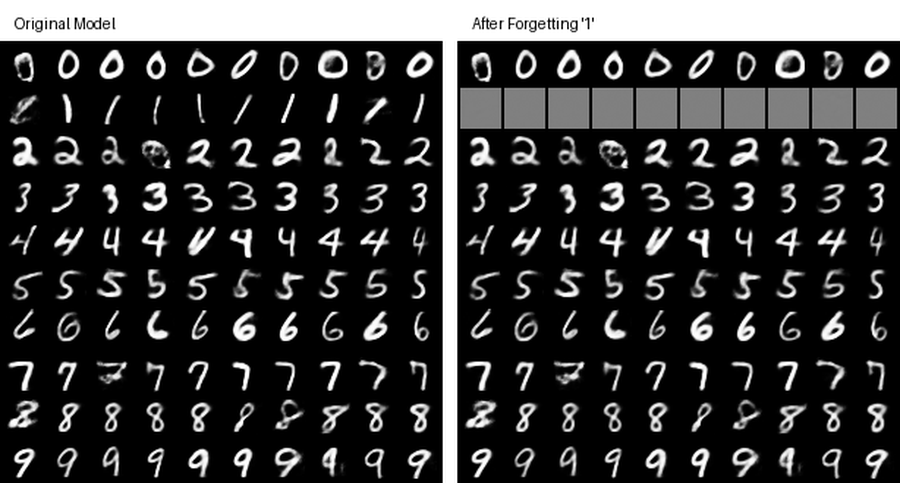

In [ ]:
gdrive_project_folder = "/content/drive/MyDrive/Colab_Selective_Amnesia"
amnesia_output_folder = os.path.join(gdrive_project_folder, "cvae_mnist_amnesia_output")
image_path = os.path.join(amnesia_output_folder, "logs", "final_amnesia_comparison.png")

print(f"Loading image from: {image_path}")

if not os.path.exists(image_path):
    print("ERROR: Image file not found. Please ensure Step 3 completed successfully.")
else:
    try:

        img = Image.open(image_path)

        desired_width = 900
        width_percent = (desired_width / float(img.size[0]))
        desired_height = int((float(img.size[1]) * float(width_percent)))

        # Resize the image
        img_resized = img.resize((desired_width, desired_height), Image.Resampling.LANCZOS)

        display(img_resized)

    except Exception as e:
        print(f"An error occurred while trying to display the image: {e}")

# 🧪 Classifier Evaluation

## train a classifier on the MNIST dataset

### Configuration

In [ ]:
gdrive_project_folder = "/content/drive/MyDrive/Colab_Selective_Amnesia"

classifier_output_folder = os.path.join(gdrive_project_folder, "classifier_output")
os.makedirs(classifier_output_folder, exist_ok=True)

classifier_config = SimpleNamespace(
    data_path="./dataset",
    batch_size=64,
    test_batch_size=1000,
    lr=1e-4,
    n_epochs=20,
    log_interval=100,

    ckpt_path=os.path.join(classifier_output_folder, "mnist_classifier.pt"),
)

### Classifier Model Definition

In [6]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(20)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.bn2(self.conv2(x))), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

### Training and Testing Functions

In [ ]:
def train(epoch, model, device, train_loader, optimizer, config):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{config.n_epochs} [Training]")
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % config.log_interval == 0:
            pbar.set_postfix(loss=loss.item())

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    logging.info(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')

### Main Execution

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f"Using device: {device}")

# Data Loaders
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(classifier_config.data_path, train=True, download=True,
                               transform=torchvision.transforms.ToTensor()),
    batch_size=classifier_config.batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(classifier_config.data_path, train=False, download=True,
                               transform=torchvision.transforms.ToTensor()),
    batch_size=classifier_config.test_batch_size, shuffle=True)

# Initialize model and optimizer
net = Classifier().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=classifier_config.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

logging.info("Starting classifier training...")
for epoch in range(1, classifier_config.n_epochs + 1):
    train(epoch, net, device, train_loader, optimizer, classifier_config)
    test(net, device, test_loader)
    scheduler.step()

# Save final trained classifier
torch.save(net.state_dict(), classifier_config.ckpt_path)
logging.info(f"Classifier training complete. Model saved to {classifier_config.ckpt_path}")

INFO - 2025-08-03 09:43:30,683 - Using device: cuda
INFO - 2025-08-03 09:43:30,772 - Starting classifier training...


Epoch 1/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:43:43,520 - 
Test set: Average loss: 0.3813, Accuracy: 9263/10000 (92.63%)



Epoch 2/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:43:55,277 - 
Test set: Average loss: 0.1931, Accuracy: 9516/10000 (95.16%)



Epoch 3/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:44:07,001 - 
Test set: Average loss: 0.1367, Accuracy: 9612/10000 (96.12%)



Epoch 4/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:44:18,743 - 
Test set: Average loss: 0.1114, Accuracy: 9677/10000 (96.77%)



Epoch 5/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:44:29,903 - 
Test set: Average loss: 0.0957, Accuracy: 9711/10000 (97.11%)



Epoch 6/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:44:41,332 - 
Test set: Average loss: 0.0941, Accuracy: 9716/10000 (97.16%)



Epoch 7/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:44:52,954 - 
Test set: Average loss: 0.0927, Accuracy: 9714/10000 (97.14%)



Epoch 8/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:45:04,706 - 
Test set: Average loss: 0.0921, Accuracy: 9723/10000 (97.23%)



Epoch 9/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:45:16,423 - 
Test set: Average loss: 0.0903, Accuracy: 9722/10000 (97.22%)



Epoch 10/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:45:28,132 - 
Test set: Average loss: 0.0892, Accuracy: 9725/10000 (97.25%)



Epoch 11/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:45:39,868 - 
Test set: Average loss: 0.0889, Accuracy: 9722/10000 (97.22%)



Epoch 12/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:45:51,737 - 
Test set: Average loss: 0.0891, Accuracy: 9725/10000 (97.25%)



Epoch 13/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:46:03,016 - 
Test set: Average loss: 0.0889, Accuracy: 9729/10000 (97.29%)



Epoch 14/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:46:14,288 - 
Test set: Average loss: 0.0887, Accuracy: 9724/10000 (97.24%)



Epoch 15/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:46:25,909 - 
Test set: Average loss: 0.0887, Accuracy: 9728/10000 (97.28%)



Epoch 16/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:46:37,647 - 
Test set: Average loss: 0.0886, Accuracy: 9722/10000 (97.22%)



Epoch 17/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:46:49,359 - 
Test set: Average loss: 0.0885, Accuracy: 9728/10000 (97.28%)



Epoch 18/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:47:01,097 - 
Test set: Average loss: 0.0886, Accuracy: 9727/10000 (97.27%)



Epoch 19/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:47:12,933 - 
Test set: Average loss: 0.0890, Accuracy: 9727/10000 (97.27%)



Epoch 20/20 [Training]:   0%|          | 0/938 [00:00<?, ?it/s]

INFO - 2025-08-03 09:47:24,863 - 
Test set: Average loss: 0.0886, Accuracy: 9727/10000 (97.27%)

INFO - 2025-08-03 09:47:24,872 - Classifier training complete. Model saved to /content/drive/MyDrive/Colab_Selective_Amnesia/classifier_output/mnist_classifier.pt


## Generate Samples for Evaluation

### Configuration

In [ ]:
gdrive_project_folder = "/content/drive/MyDrive/Colab_Selective_Amnesia"
original_output_folder = os.path.join(gdrive_project_folder, "cvae_mnist_output")
amnesia_output_folder = os.path.join(gdrive_project_folder, "cvae_mnist_amnesia_output")

gen_config = SimpleNamespace(

    original_vae_ckpt=os.path.join(original_output_folder, "checkpoints/cvae_mnist_final.pt"),
    amnesia_vae_ckpt=os.path.join(amnesia_output_folder, "checkpoints/amnesia_model_final.pt"),

    n_samples=1000,
    batch_size=1000,
    label_to_generate=1, # The digit we trained the model to forget

    original_samples_dir=os.path.join(original_output_folder, "generated_samples"),
    amnesia_samples_dir=os.path.join(amnesia_output_folder, "generated_samples"),
)

### Helper Function

In [ ]:
def generate_and_save(model, config, save_dir, device):
    """Generates samples and saves them"""
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    num_generated = 0
    with torch.no_grad():
        pbar = tqdm(range(config.n_samples // config.batch_size), desc=f"Generating in {os.path.basename(save_dir)}")
        for _ in pbar:
            z = torch.randn((config.batch_size, model.fc31.out_features)).to(device)
            c = F.one_hot(torch.full((config.batch_size,), config.label_to_generate), 10).float().to(device)
            samples = model.decoder(z, c).view(-1, 1, 28, 28)
            for sample in samples:
                save_path = os.path.join(save_dir, f'{num_generated}.png')
                save_image(sample, save_path)
                num_generated += 1
    print(f"Successfully saved {num_generated} images to: {save_dir}\n")

### Main Execution

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}\n")

try:
    print("--- Loading Original VAE ---")
    orig_checkpoint = torch.load(gen_config.original_vae_ckpt, map_location=device, weights_only=False)
    config_from_ckpt = orig_checkpoint['config']
    original_vae = OneHotCVAE(config_from_ckpt.x_dim, config_from_ckpt.h_dim1, config_from_ckpt.h_dim2, config_from_ckpt.z_dim).to(device)
    original_vae.load_state_dict(orig_checkpoint['model_state_dict'])
    generate_and_save(original_vae, gen_config, gen_config.original_samples_dir, device)

    print("--- Loading Amnesiac VAE ---")
    amnesia_checkpoint = torch.load(gen_config.amnesia_vae_ckpt, map_location=device, weights_only=False)
    config_from_ckpt = amnesia_checkpoint['config']
    amnesia_vae = OneHotCVAE(config_from_ckpt.x_dim, config_from_ckpt.h_dim1, config_from_ckpt.h_dim2, config_from_ckpt.z_dim).to(device)
    amnesia_vae.load_state_dict(amnesia_checkpoint['model_state_dict'])
    generate_and_save(amnesia_vae, gen_config, gen_config.amnesia_samples_dir, device)

    print("All samples generated successfully.")

except FileNotFoundError as e:
    print(f"ERROR: Could not find a required model file. Please ensure all previous steps ran successfully. Details: {e}")

Using device: cuda

--- Loading Original VAE ---


Generating in generated_samples:   0%|          | 0/1 [00:00<?, ?it/s]

Successfully saved 1000 images to: /content/drive/MyDrive/Colab_Selective_Amnesia/cvae_mnist_output/generated_samples

--- Loading Amnesiac VAE ---


Generating in generated_samples:   0%|          | 0/1 [00:00<?, ?it/s]

Successfully saved 1000 images to: /content/drive/MyDrive/Colab_Selective_Amnesia/cvae_mnist_amnesia_output/generated_samples

All samples generated successfully.


## Evaluate with the classifier

### Configuration

In [ ]:
gdrive_project_folder = "/content/drive/MyDrive/Colab_Selective_Amnesia"
original_output_folder = os.path.join(gdrive_project_folder, "cvae_mnist_output")
amnesia_output_folder = os.path.join(gdrive_project_folder, "cvae_mnist_amnesia_output")
classifier_output_folder = os.path.join(gdrive_project_folder, "classifier_output")

eval_config = SimpleNamespace(

    classifier_ckpt=os.path.join(classifier_output_folder, "mnist_classifier.pt"),

    original_samples_dir=os.path.join(original_output_folder, "generated_samples"),
    amnesia_samples_dir=os.path.join(amnesia_output_folder, "generated_samples"),

    label_to_evaluate=1, # The label we tried to forget
    batch_size=256,
)

### Evaluation Function

In [ ]:
def evaluate_from_loader(classifier, loader, config, device):
    """Evaluates images from a DataLoader using the classifier."""

    classifier.eval()
    all_probs = []
    with torch.no_grad():
        for data in tqdm(loader, desc="Evaluating with Classifier"):
            log_probs = classifier(data.to(device))
            probs = torch.exp(log_probs)
            all_probs.append(probs.cpu())
    all_probs = torch.cat(all_probs, dim=0)
    prob_forgotten = all_probs[:, config.label_to_evaluate].mean().item()
    entropy = -torch.sum(all_probs * torch.log(all_probs + 1e-9), dim=1).mean().item()
    return prob_forgotten, entropy

In [ ]:
class ImagePathDataset(torch.utils.data.Dataset):
    """Custom Dataset for loading images from a folder."""
    def __init__(self, img_folder, transforms=None):
        self.transforms = transforms
        path = pathlib.Path(img_folder)
        self.files = sorted([file for ext in {'png'} for file in path.glob(f'*.{ext}')])
        if len(self.files) == 0:
            raise FileNotFoundError(f"No images found in {img_folder}. Please ensure samples were generated correctly in the previous step.")
    def __len__(self):
        return len(self.files)
    def __getitem__(self, i):
        path = self.files[i]
        img = Image.open(path).convert('L')
        if self.transforms:
            img = self.transforms(img)
        return img

### Main Execution

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
try:
    # Load the trained classifier
    classifier = Classifier().to(device)
    classifier.load_state_dict(torch.load(eval_config.classifier_ckpt, map_location=device))
    print("Classifier model loaded successfully.\n")

    # Create DataLoaders from the pre-saved sample folders
    original_dataset = ImagePathDataset(eval_config.original_samples_dir, transforms=transforms.ToTensor())
    amnesia_dataset = ImagePathDataset(eval_config.amnesia_samples_dir, transforms=transforms.ToTensor())
    original_loader = DataLoader(original_dataset, batch_size=eval_config.batch_size)
    amnesia_loader = DataLoader(amnesia_dataset, batch_size=eval_config.batch_size)
    print(f"Found {len(original_dataset)} samples for the original model.")
    print(f"Found {len(amnesia_dataset)} samples for the amnesiac model.\n")

    # Run evaluation on the loaded samples
    print(f"--- Evaluating Forgetting for Digit '{eval_config.label_to_evaluate}' ---")
    prob_orig, entropy_orig = evaluate_from_loader(classifier, original_loader, eval_config, device)
    print("\nOriginal Model (Before Forgetting):")
    print(f"  - Avg. Probability of seeing a '{eval_config.label_to_evaluate}': {prob_orig:.4f} (Expected: High, close to 1.0)")
    print(f"  - Classifier Entropy: {entropy_orig:.4f} (Expected: Low)")

    prob_amnesia, entropy_amnesia = evaluate_from_loader(classifier, amnesia_loader, eval_config, device)
    print("\nAmnesiac Model (After Forgetting):")
    print(f"  - Avg. Probability of seeing a '{eval_config.label_to_evaluate}': {prob_amnesia:.4f} (Expected: Low, close to 0.1)")
    print(f"  - Classifier Entropy: {entropy_amnesia:.4f} (Expected: High, close to log(10) ≈ 2.3)")

except FileNotFoundError as e:
    print(f"ERROR: Could not find a required model or data file. Please ensure all previous steps ran successfully. Details: {e}")

Classifier model loaded successfully.

Found 1000 samples for the original model.
Found 1000 samples for the amnesiac model.

--- Evaluating Forgetting for Digit '1' ---


Evaluating with Classifier:   0%|          | 0/4 [00:00<?, ?it/s]


Original Model (Before Forgetting):
  - Avg. Probability of seeing a '1': 0.9704 (Expected: High, close to 1.0)
  - Classifier Entropy: 0.0999 (Expected: Low)


Evaluating with Classifier:   0%|          | 0/4 [00:00<?, ?it/s]


Amnesiac Model (After Forgetting):
  - Avg. Probability of seeing a '1': 0.2045 (Expected: Low, close to 0.1)
  - Classifier Entropy: 2.2175 (Expected: High, close to log(10) ≈ 2.3)


# 🔬 Sequential Forgetting and Generalization Check

This part investigates if repeatedly applying Selective Amnesia degrades
the model's ability to generate the remaining "remembered" classes.
It sequentially trains the model to forget four different digits and
evaluates performance at each stage.

## Configuration

In [5]:
gdrive_project_folder = "/content/drive/MyDrive/Colab_Selective_Amnesia"
original_output_folder = os.path.join(gdrive_project_folder, "cvae_mnist_output")

amnesia_base_folder = os.path.join(gdrive_project_folder, "sequential_amnesia")

seq_config = SimpleNamespace(
    # Forgetting Parameters
    labels_to_forget = [0, 1, 2, 3, 4],
    retained_label_to_check = 9,

    # SA parameters
    lmbda=100,
    gamma=1.0,
    n_iters=10000,
    lr=1e-4,
    batch_size=256,
    n_fim_samples=50000,

    output_dir=amnesia_base_folder,
)

os.makedirs(os.path.join(seq_config.output_dir, "logs"), exist_ok=True)
os.makedirs(os.path.join(seq_config.output_dir, "checkpoints"), exist_ok=True)

## Helper Functions

In [6]:
def calculate_fim(model, device, config, remember_classes):
    fisher_matrix = {name: torch.zeros_like(param.data) for name, param in model.named_parameters() if param.requires_grad}
    model.eval()
    pbar = tqdm(range(config.n_fim_samples // config.batch_size), desc="Calculating FIM")
    for _ in pbar:
        with torch.no_grad():
            z = torch.randn(config.batch_size, model.fc31.out_features).to(device)
            c_labels = torch.tensor(np.random.choice(remember_classes, size=config.batch_size)).to(device)
            c_one_hot = F.one_hot(c_labels, 10).float()
            generated_data = model.decoder(z, c_one_hot)
        model.zero_grad()
        recon_x, mu, log_var = model(generated_data, c_one_hot)
        loss = loss_function(recon_x, generated_data, mu, log_var) / config.batch_size
        loss.backward()
        for name, param in model.named_parameters():
            if param.grad is not None:
                fisher_matrix[name] += param.grad.data.pow(2) * config.batch_size
    for name in fisher_matrix:
        fisher_matrix[name] /= config.n_fim_samples
    return fisher_matrix

def train_amnesia_step(config, vae, original_params, fisher_dict, device, label_to_forget, already_forgotten):
    vae_clone = copy.deepcopy(vae); vae_clone.eval()
    remember_labels = [c for c in range(10) if c not in already_forgotten and c != label_to_forget]
    vae.train()
    optimizer = optim.Adam(vae.parameters(), lr=config.lr)
    pbar = tqdm(range(1, config.n_iters + 1), desc=f"Forgetting Digit '{label_to_forget}'")
    for step in pbar:
        optimizer.zero_grad()
        q_x_forget = torch.rand((config.batch_size, 784)).to(device)
        c_forget = F.one_hot(torch.full((config.batch_size,), label_to_forget), 10).float().to(device)
        with torch.no_grad():
            c_remember_labels = torch.tensor(np.random.choice(remember_labels, size=config.batch_size)).to(device)
            c_remember = F.one_hot(c_remember_labels, 10).float()
            z_remember = torch.randn((config.batch_size, vae.fc31.out_features)).to(device)
            p_x_remember = vae_clone.decoder(z_remember, c_remember)
        recon_forget, mu_f, log_var_f = vae(q_x_forget, c_forget)
        loss_forget = loss_function(recon_forget, q_x_forget, mu_f, log_var_f)
        recon_remember, mu_r, log_var_r = vae(p_x_remember, c_remember)
        loss_remember = loss_function(recon_remember, p_x_remember, mu_r, log_var_r)
        ewc_loss = sum((fisher_dict[name] * (param - original_params[name]).pow(2)).sum() for name, param in vae.named_parameters() if name in fisher_dict)
        total_loss = loss_forget + (config.gamma * loss_remember) + (config.lmbda / 2) * ewc_loss
        total_loss.backward()
        optimizer.step()
        if step % 2000 == 0:
            pbar.set_postfix(loss=total_loss.item())

## Main Execution

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("--- Loading Prerequisite Models ---")
orig_vae_ckpt = torch.load(os.path.join(original_output_folder, "checkpoints/cvae_mnist_final.pt"), map_location=device, weights_only=False)
config_from_ckpt = orig_vae_ckpt['config']
original_vae = OneHotCVAE(config_from_ckpt.x_dim, config_from_ckpt.h_dim1, config_from_ckpt.h_dim2, config_from_ckpt.z_dim).to(device)
original_vae.load_state_dict(orig_vae_ckpt['model_state_dict'])
classifier = Classifier().to(device)
classifier.load_state_dict(torch.load(os.path.join(gdrive_project_folder, "classifier_output/mnist_classifier.pt"), map_location=device))
print("Models loaded successfully.\n")

amnesiac_models = [original_vae]
current_model = original_vae
forgotten_labels_so_far = []

for i, label_to_forget in enumerate(seq_config.labels_to_forget):
    print(f"--- Starting Round {i+1}: Forgetting Digit '{label_to_forget}' ---")

    # Calculate FIM on current model
    remember_classes_for_fim = [c for c in range(10) if c not in forgotten_labels_so_far]
    fisher_dict = calculate_fim(current_model, device, seq_config, remember_classes_for_fim)

    # Prepare for the next step
    current_params = {name: param.clone().detach() for name, param in current_model.named_parameters()}
    next_model = copy.deepcopy(current_model)

    # forget the new digit
    train_amnesia_step(seq_config, next_model, current_params, fisher_dict, device, label_to_forget, forgotten_labels_so_far)

    # Save the model
    save_path = os.path.join(seq_config.output_dir, f"checkpoints/amnesia_model_forgot_{i+1}.pt")
    torch.save(next_model.state_dict(), save_path)
    print(f"Saved model that has forgotten {i+1} digit(s) to {save_path}\n")

    # Update state
    amnesiac_models.append(next_model)
    current_model = next_model
    forgotten_labels_so_far.append(label_to_forget)

--- Loading Prerequisite Models ---
Models loaded successfully.

--- Starting Round 1: Forgetting Digit '0' ---


Calculating FIM:   0%|          | 0/195 [00:00<?, ?it/s]

Forgetting Digit '0':   0%|          | 0/10000 [00:00<?, ?it/s]

Saved model that has forgotten 1 digit(s) to /content/drive/MyDrive/Colab_Selective_Amnesia/sequential_amnesia/checkpoints/amnesia_model_forgot_1.pt

--- Starting Round 2: Forgetting Digit '1' ---


Calculating FIM:   0%|          | 0/195 [00:00<?, ?it/s]

Forgetting Digit '1':   0%|          | 0/10000 [00:00<?, ?it/s]

Saved model that has forgotten 2 digit(s) to /content/drive/MyDrive/Colab_Selective_Amnesia/sequential_amnesia/checkpoints/amnesia_model_forgot_2.pt

--- Starting Round 3: Forgetting Digit '2' ---


Calculating FIM:   0%|          | 0/195 [00:00<?, ?it/s]

Forgetting Digit '2':   0%|          | 0/10000 [00:00<?, ?it/s]

Saved model that has forgotten 3 digit(s) to /content/drive/MyDrive/Colab_Selective_Amnesia/sequential_amnesia/checkpoints/amnesia_model_forgot_3.pt

--- Starting Round 4: Forgetting Digit '3' ---


Calculating FIM:   0%|          | 0/195 [00:00<?, ?it/s]

Forgetting Digit '3':   0%|          | 0/10000 [00:00<?, ?it/s]

Saved model that has forgotten 4 digit(s) to /content/drive/MyDrive/Colab_Selective_Amnesia/sequential_amnesia/checkpoints/amnesia_model_forgot_4.pt

--- Starting Round 5: Forgetting Digit '4' ---


Calculating FIM:   0%|          | 0/195 [00:00<?, ?it/s]

Forgetting Digit '4':   0%|          | 0/10000 [00:00<?, ?it/s]

Saved model that has forgotten 5 digit(s) to /content/drive/MyDrive/Colab_Selective_Amnesia/sequential_amnesia/checkpoints/amnesia_model_forgot_5.pt



## Visual and Quantitative Evaluation

Saved multi-way comparison image to /content/drive/MyDrive/Colab_Selective_Amnesia/sequential_amnesia/logs/sequential_forgetting_comparison.png


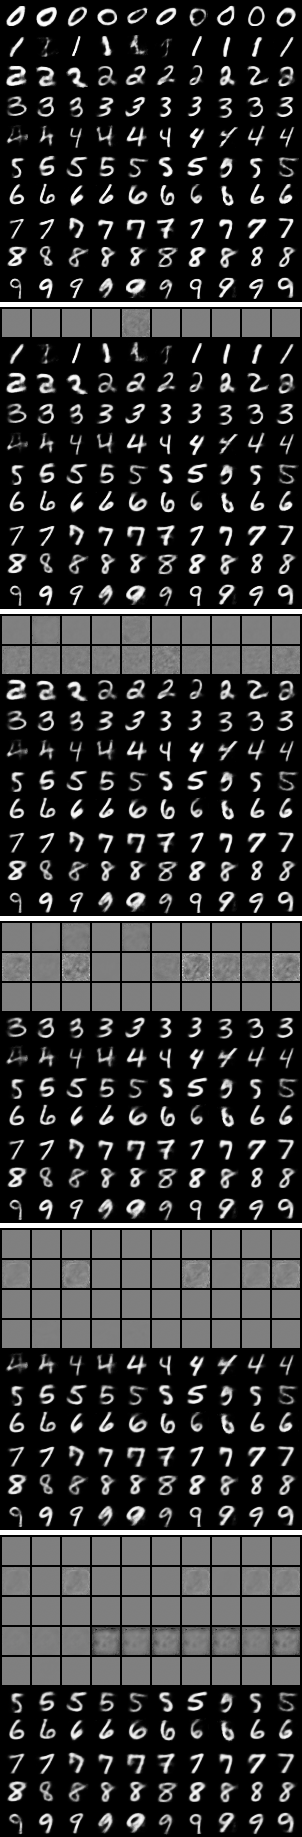

In [8]:
for model in amnesiac_models: model.eval()
classifier.eval()

with torch.no_grad():
    z = torch.randn((100, original_vae.fc31.out_features)).to(device)
    c = F.one_hot(torch.arange(10).repeat_interleave(10), 10).float().to(device)

    all_grids = [make_grid(model.decoder(z, c).view(-1, 1, 28, 28), nrow=10) for model in amnesiac_models]

    separator = torch.ones(3, 5, all_grids[0].shape[2]).to(device)

    interleaved = []
    for grid in all_grids:
        interleaved.append(grid)
        interleaved.append(separator)

    comparison_grid = torch.cat(interleaved[:-1], dim=1)
    save_path = os.path.join(seq_config.output_dir, "logs/sequential_forgetting_comparison.png")
    save_image(comparison_grid, save_path)
    print(f"Saved multi-way comparison image to {save_path}")
    display(Image.open(save_path))

## Quantitative evaluation of the RETAINED digit

In [9]:
print(f"\n--- Quantitative Evaluation of Retained Digit '{seq_config.retained_label_to_check}' ---")
with torch.no_grad():
    z = torch.randn((1000, original_vae.fc31.out_features)).to(device)
    c = F.one_hot(torch.full((1000,), seq_config.retained_label_to_check), 10).float().to(device)

    print(f"Classifier confidence for digit '{seq_config.retained_label_to_check}':")
    for i, model in enumerate(amnesiac_models):
        samples = model.decoder(z, c).view(-1, 1, 28, 28)
        probs = torch.exp(classifier(samples))
        prob = probs[:, seq_config.retained_label_to_check].mean().item()
        if i == 0:
            print(f"  - Original Model:         {prob:.4f}")
        else:
            print(f"  - After Forgetting {i}:   {prob:.4f}")


--- Quantitative Evaluation of Retained Digit '9' ---
Classifier confidence for digit '9':
  - Original Model:         0.9133
  - After Forgetting 1:   0.9252
  - After Forgetting 2:   0.9315
  - After Forgetting 3:   0.9306
  - After Forgetting 4:   0.9270
  - After Forgetting 5:   0.9193


# 🔍 Latent Space Exploration of Forgotten Class

## 1th Approach: Latent Space Exploration of Forgotten Class

This cell investigates whether the forgotten digit can still be generated
by randomly sampling the latent space. It loads the model that has forgotten
one digit, generates samples using the forgotten label, and then uses the
expert classifier to identify the output.


### Configuration

In [48]:
gdrive_project_folder = "/content/drive/MyDrive/Colab_Selective_Amnesia"
amnesia_output_folder = os.path.join(gdrive_project_folder, "cvae_mnist_amnesia_output")
classifier_output_folder = os.path.join(gdrive_project_folder, "classifier_output")

explore_config = SimpleNamespace(
    amnesia_vae_ckpt=os.path.join(amnesia_output_folder, "checkpoints/amnesia_model_final.pt"),

    classifier_ckpt=os.path.join(classifier_output_folder, "mnist_classifier.pt"),

    label_to_test=1,      # The digit that was forgotten in the first amnesia step
    num_samples=100,      # How many random samples to generate
    batch_size=100,

    output_image_path=os.path.join(amnesia_output_folder, "logs/latent_space_exploration.png"),
)

### Main Execution

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
try:
    # Loading Models
    amnesia_ckpt = torch.load(explore_config.amnesia_vae_ckpt, map_location=device, weights_only=False)
    config_from_ckpt = amnesia_ckpt['config']
    amnesiac_vae = OneHotCVAE(config_from_ckpt.x_dim, config_from_ckpt.h_dim1, config_from_ckpt.h_dim2, config_from_ckpt.z_dim).to(device)
    amnesiac_vae.load_state_dict(amnesia_ckpt['model_state_dict'])
    amnesiac_vae.eval()

    classifier = Classifier().to(device)
    classifier.load_state_dict(torch.load(explore_config.classifier_ckpt, map_location=device))
    classifier.eval()

    # Generate Samples
    with torch.no_grad():
        z = torch.randn(explore_config.num_samples, amnesiac_vae.fc31.out_features).to(device)
        c = F.one_hot(torch.full((explore_config.num_samples,), explore_config.label_to_test), 10).float().to(device) * 0.1

        # Generate samples from the amnesiac VAE
        generated_samples = amnesiac_vae.decoder(z, c).view(-1, 1, 28, 28)

        # Get classifier predictions
        log_probs = classifier(generated_samples)
        predictions = torch.argmax(log_probs, dim=1)

except FileNotFoundError as e:
    print(f"ERROR: Could not find a required model file. Please ensure all previous steps ran successfully. Details: {e}")



### Analyze and Display Results


--- Analysis of Generated Samples ---
Classifier predictions for the generated images:
  - Predicted as Digit '0': 20 times
  - Predicted as Digit '1': 8 times
  - Predicted as Digit '2': 11 times
  - Predicted as Digit '3': 5 times
  - Predicted as Digit '4': 11 times
  - Predicted as Digit '5': 2 times
  - Predicted as Digit '6': 11 times
  - Predicted as Digit '7': 10 times
  - Predicted as Digit '8': 13 times
  - Predicted as Digit '9': 9 times

Conclusion: The forgotten digit '1' was generated 8 out of 100 times.
This is close to random chance, suggesting the forgetting was effective.

 Grid of Generated Samples:


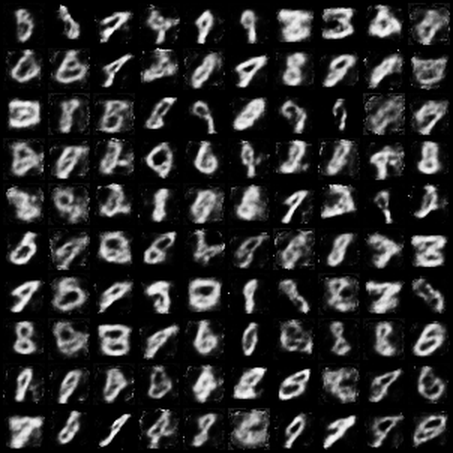

In [51]:
print("\n--- Analysis of Generated Samples ---")

counts = torch.bincount(predictions, minlength=10)

print("Classifier predictions for the generated images:")
for i in range(10):
    print(f"  - Predicted as Digit '{i}': {counts[i].item()} times")

forgotten_count = counts[explore_config.label_to_test].item()
print(f"\nConclusion: The forgotten digit '{explore_config.label_to_test}' was generated {forgotten_count} out of {explore_config.num_samples} times.")
if forgotten_count > explore_config.num_samples * 0.1:
      print("This is more than random chance, suggesting some information may remain.")
else:
      print("This is close to random chance, suggesting the forgetting was effective.")

print("\n Grid of Generated Samples:")
grid = make_grid(generated_samples, nrow=10, padding=2)
save_image(grid, explore_config.output_image_path)

img = Image.open(explore_config.output_image_path)

scale_factor = 1.5
new_width = int(img.size[0] * scale_factor)
new_height = int(img.size[1] * scale_factor)
img_resized = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

display(img_resized)

## 2th Approach: Latent Space Reconstruction Test with Noisy Conditions

This part performs a test to probe the amnesiac model's memory.
It finds the "true" latent coordinates for a forgotten digit using the original VAE,
then provides those coordinates along with a NOISY/FUZZY condition vector to the
amnesiac VAE's decoder to see if the forgotten concept can be recovered.

1.   Get the "true" latent coordinates for the forgotten digit using the original VAE's encoder.

2.   Create a noisy condition vector. Instead of the perfect [1, 0, 0, ...], it will be something like [0.9, 0.05, 0.0, ...].

3.   Feed both the latent coordinates and this new noisy condition vector into the amnesiac VAE's decoder.

4.   Display the results and the classifier's analysis to see if this trick was able to recover the forgotten digit.

### Configuration

In [38]:
gdrive_project_folder = "/content/drive/MyDrive/Colab_Selective_Amnesia"
original_output_folder = os.path.join(gdrive_project_folder, "cvae_mnist_output")
amnesia_output_folder = os.path.join(gdrive_project_folder, "cvae_mnist_amnesia_output")
classifier_output_folder = os.path.join(gdrive_project_folder, "classifier_output")

explore_config = SimpleNamespace(

    original_vae_ckpt=os.path.join(original_output_folder, "checkpoints/cvae_mnist_final.pt"),
    amnesia_vae_ckpt=os.path.join(amnesia_output_folder, "checkpoints/amnesia_model_final.pt"),
    classifier_ckpt=os.path.join(classifier_output_folder, "mnist_classifier.pt"),

    label_to_test=1,              # The digit that was forgotten
    num_samples_to_reconstruct=10,
    latent_noise_level=0.1,       # How much noise to add to the latent coordinates
    condition_noise_level=0.1,    # How much noise to add to the condition vector

    output_image_path=os.path.join(amnesia_output_folder, "logs/reconstruction_test_noisy_condition.png"),
)

### Main Execution

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

try:
    # Load the Models

    orig_ckpt = torch.load(explore_config.original_vae_ckpt, map_location=device, weights_only=False)
    config_from_ckpt = orig_ckpt['config']
    original_vae = OneHotCVAE(config_from_ckpt.x_dim, config_from_ckpt.h_dim1, config_from_ckpt.h_dim2, config_from_ckpt.z_dim).to(device)
    original_vae.load_state_dict(orig_ckpt['model_state_dict'])
    original_vae.eval()

    amnesia_ckpt = torch.load(explore_config.amnesia_vae_ckpt, map_location=device, weights_only=False)
    amnesiac_vae = OneHotCVAE(config_from_ckpt.x_dim, config_from_ckpt.h_dim1, config_from_ckpt.h_dim2, config_from_ckpt.z_dim).to(device)
    amnesiac_vae.load_state_dict(amnesia_ckpt['model_state_dict'])
    amnesiac_vae.eval()

    classifier = Classifier().to(device)
    classifier.load_state_dict(torch.load(explore_config.classifier_ckpt, map_location=device))
    classifier.eval()

    mnist_dataset = torchvision.datasets.MNIST("./dataset", train=False, download=True, transform=torchvision.transforms.ToTensor())

    # Get Real Images of the Forgotten Class
    real_images = []
    for img, label in mnist_dataset:
        if label == explore_config.label_to_test:
            real_images.append(img)
        if len(real_images) == explore_config.num_samples_to_reconstruct:
            break
    real_images_tensor = torch.stack(real_images).to(device)
    c_true = F.one_hot(torch.full((explore_config.num_samples_to_reconstruct,), explore_config.label_to_test), 10).float().to(device)

    # Perform Reconstruction
    with torch.no_grad():
        # Get the "true" latent coordinates from the ORIGINAL VAE's encoder
        mu_orig, log_var_orig = original_vae.encoder(real_images_tensor, c_true)
        z_true = original_vae.sampling(mu_orig, log_var_orig)

        # Reconstruct with Original VAE (baseline)
        recon_orig = original_vae.decoder(z_true, c_true).view(-1, 1, 28, 28)

        # Add noise to the latent coordinates
        z_noisy = z_true + torch.randn_like(z_true) * explore_config.latent_noise_level

        # Create a NOISY condition vector
        c_noisy = c_true + torch.rand_like(c_true) * explore_config.condition_noise_level
        c_noisy = F.softmax(c_noisy, dim=1) # Re-normalize to make it a valid probability distribution

        # Reconstruct with Amnesiac VAE from the noisy latent AND noisy condition
        recon_amnesia = amnesiac_vae.decoder(z_noisy, c_noisy).view(-1, 1, 28, 28)

        # Get classifier predictions for the amnesiac reconstructions
        log_probs = classifier(recon_amnesia)
        predictions = torch.argmax(log_probs, dim=1)

except FileNotFoundError as e:
    print(f"ERROR: Could not find a required model file. Please ensure all previous steps ran successfully. Details: {e}")



### Analyze and Display Results


--- Analysis of Reconstructed Samples ---
Classifier predictions for the images reconstructed by the AMNESIAC model from the ORIGINAL latent space with a NOISY condition:
  - Predicted as Digit '0': 1 times
  - Predicted as Digit '1': 0 times
  - Predicted as Digit '2': 0 times
  - Predicted as Digit '3': 0 times
  - Predicted as Digit '4': 0 times
  - Predicted as Digit '5': 1 times
  - Predicted as Digit '6': 0 times
  - Predicted as Digit '7': 0 times
  - Predicted as Digit '8': 5 times
  - Predicted as Digit '9': 3 times

--- Visual Comparison ---
Saved comparison grid to: /content/drive/MyDrive/Colab_Selective_Amnesia/cvae_mnist_amnesia_output/logs/reconstruction_test_noisy_condition.png


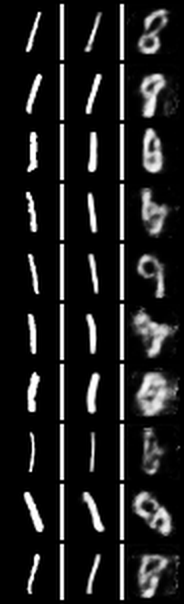

In [44]:
print("\n--- Analysis of Reconstructed Samples ---")
counts = torch.bincount(predictions, minlength=10)
print("Classifier predictions for the images reconstructed by the AMNESIAC model from the ORIGINAL latent space with a NOISY condition:")
for i in range(10):
    print(f"  - Predicted as Digit '{i}': {counts[i].item()} times")


print("\n--- Visual Comparison ---")
separator = torch.ones(real_images_tensor.shape[0], 1, 28, 2).to(device)

comparison_tensor = torch.cat([real_images_tensor, separator, recon_orig, separator, recon_amnesia], dim=3)

grid = make_grid(comparison_tensor, nrow=1, padding=2)

save_image(grid, explore_config.output_image_path)
print(f"Saved comparison grid to: {explore_config.output_image_path}")

img = Image.open(explore_config.output_image_path)

scale_factor = 2
new_width = int(img.size[0] * scale_factor)
new_height = int(img.size[1] * scale_factor)
img_resized = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

display(img_resized)


## 3th Approach: Latent Walk with a "Deceptive" Condition

We will walk through the latent space from a remembered digit to the forgotten one, but we will lie to the decoder about what it's supposed to be drawing.

*   **Find Latent Locations:** We'll use the original VAE to find the exact latent space coordinates for a real '7' (z_7) and a real '1' (z_1).

*   **Walk the Path**: We will create a smooth path of latent vectors from z_7 to z_1.

*   **Provide a Fixed, "Deceptive" Condition:** As we feed each point on this path to the amnesiac decoder, we will always tell it that the digit is an '7'.


The model was trained to suppress its output for the combination of a '1' latent code and a '1' condition. It may not have learned to suppress the output for the combination of a '1' latent code and an '7' condition. By doing this, we might trick the decoder into revealing the "ghost" of the '1' shape that still exists at that latent location, but interpreted through the "lens" of an '7'.

### Configuration

In [34]:
gdrive_project_folder = "/content/drive/MyDrive/Colab_Selective_Amnesia"
original_output_folder = os.path.join(gdrive_project_folder, "cvae_mnist_output")
amnesia_output_folder = os.path.join(gdrive_project_folder, "cvae_mnist_amnesia_output")

interp_config = SimpleNamespace(
    original_vae_ckpt=os.path.join(original_output_folder, "checkpoints/cvae_mnist_final.pt"),
    amnesia_vae_ckpt=os.path.join(amnesia_output_folder, "checkpoints/amnesia_model_final.pt"),

    start_label=7,              # A digit the model remembers well
    end_label=1,                # The digit that was forgotten
    num_interpolation_steps=12, # Number of images to generate between start and end

    output_image_path=os.path.join(amnesia_output_folder, "logs/interpolation_test_fixed_condition.png"),
)

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

try:

    orig_ckpt = torch.load(interp_config.original_vae_ckpt, map_location=device, weights_only=False)
    config_from_ckpt = orig_ckpt['config']
    original_vae = OneHotCVAE(config_from_ckpt.x_dim, config_from_ckpt.h_dim1, config_from_ckpt.h_dim2, config_from_ckpt.z_dim).to(device)
    original_vae.load_state_dict(orig_ckpt['model_state_dict'])
    original_vae.eval()

    amnesia_ckpt = torch.load(interp_config.amnesia_vae_ckpt, map_location=device, weights_only=False)
    amnesiac_vae = OneHotCVAE(config_from_ckpt.x_dim, config_from_ckpt.h_dim1, config_from_ckpt.h_dim2, config_from_ckpt.z_dim).to(device)
    amnesiac_vae.load_state_dict(amnesia_ckpt['model_state_dict'])
    amnesiac_vae.eval()

    mnist_dataset = torchvision.datasets.MNIST("./dataset", train=False, download=True, transform=torchvision.transforms.ToTensor())

    # Find one image for the start label
    start_image = next(img for img, label in mnist_dataset if label == interp_config.start_label).to(device)
    # Find one image for the end label
    end_image = next(img for img, label in mnist_dataset if label == interp_config.end_label).to(device)

    with torch.no_grad():
        # Get latent coordinates from the ORIGINAL VAE
        c_start_true = F.one_hot(torch.tensor([interp_config.start_label]), 10).float().to(device)
        mu_start, _ = original_vae.encoder(start_image.unsqueeze(0), c_start_true)

        c_end_true = F.one_hot(torch.tensor([interp_config.end_label]), 10).float().to(device)
        mu_end, _ = original_vae.encoder(end_image.unsqueeze(0), c_end_true)

    # Perform Interpolation
    interpolation_images = []
    with torch.no_grad():
        for i in range(interp_config.num_interpolation_steps):
            alpha = i / (interp_config.num_interpolation_steps - 1)

            # Interpolate the latent vector (z)
            z_interp = (1 - alpha) * mu_start + alpha * mu_end

            # c_fixed = c_end_true + torch.rand_like(c_end_true) * 1.5
            c_fixed = c_start_true

            # Decode using the AMNESIAC VAE's decoder with the deceptive condition
            recon_image = amnesiac_vae.decoder(z_interp, c_fixed).view(1, 1, 28, 28)
            interpolation_images.append(recon_image)

except FileNotFoundError as e:
    print(f"ERROR: Could not find a required model file. Please ensure all previous steps ran successfully. Details: {e}")



### Visualize the Result

--- Interpolation Sequence (Latent space walk from 7 to 1, but always telling the model it's an 8) ---
Saved interpolation grid to: /content/drive/MyDrive/Colab_Selective_Amnesia/cvae_mnist_amnesia_output/logs/interpolation_test_fixed_condition.png


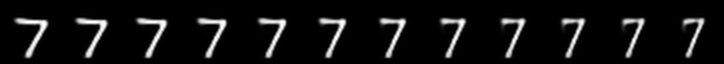

In [37]:
print("--- Interpolation Sequence (Latent space walk from 7 to 1, but always telling the model it's an 8) ---")
all_images = torch.cat(interpolation_images, dim=0)
grid = make_grid(all_images, nrow=interp_config.num_interpolation_steps, padding=2)

save_image(grid, interp_config.output_image_path)
print(f"Saved interpolation grid to: {interp_config.output_image_path}")

img = Image.open(interp_config.output_image_path)

scale_factor = 2
new_width = int(img.size[0] * scale_factor)
new_height = int(img.size[1] * scale_factor)
img_resized = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

display(img_resized)

## 4th Approach: Double Interpolation

We will walk through the latent space and the "condition space" simultaneously.

*   **Find Start/End Latent Points:** We'll get the latent coordinates for a real '7' (z_7) and a real '1' (z_1) from the original VAE.

*   **Find Start/End Condition Vectors:** We'll get the perfect one-hot condition vectors for '7' (c_7) and '1' (c_1).

*   **Walk Both Paths:** We will create a smooth path from z_7 to z_1 and, at the same time, a smooth path from c_7 to c_1.

*   **Decode with the Amnesiac Model:** For each step, we will feed the corresponding interpolated latent vector and interpolated condition vector to the amnesiac VAE's decoder.

As the condition vector slowly shifts from "definitely a 7" towards "definitely a 1", we might see the ghost of the forgotten '1' appear, even if for just a moment, before the model's unlearning kicks in and suppresses it.

### Configuration

In [30]:
gdrive_project_folder = "/content/drive/MyDrive/Colab_Selective_Amnesia"
original_output_folder = os.path.join(gdrive_project_folder, "cvae_mnist_output")
amnesia_output_folder = os.path.join(gdrive_project_folder, "cvae_mnist_amnesia_output")

interp_config = SimpleNamespace(
    original_vae_ckpt=os.path.join(original_output_folder, "checkpoints/cvae_mnist_final.pt"),
    amnesia_vae_ckpt=os.path.join(amnesia_output_folder, "checkpoints/amnesia_model_final.pt"),

    start_label=7,              # A digit the model remembers well
    end_label=1,                # The digit that was forgotten
    num_interpolation_steps=12, # Number of images to generate between start and end

    output_image_path=os.path.join(amnesia_output_folder, "logs/double_interpolation_test.png"),
)

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

try:
    # Load the Models
    orig_ckpt = torch.load(interp_config.original_vae_ckpt, map_location=device, weights_only=False)
    config_from_ckpt = orig_ckpt['config']
    original_vae = OneHotCVAE(config_from_ckpt.x_dim, config_from_ckpt.h_dim1, config_from_ckpt.h_dim2, config_from_ckpt.z_dim).to(device)
    original_vae.load_state_dict(orig_ckpt['model_state_dict'])
    original_vae.eval()

    amnesia_ckpt = torch.load(interp_config.amnesia_vae_ckpt, map_location=device, weights_only=False)
    amnesiac_vae = OneHotCVAE(config_from_ckpt.x_dim, config_from_ckpt.h_dim1, config_from_ckpt.h_dim2, config_from_ckpt.z_dim).to(device)
    amnesiac_vae.load_state_dict(amnesia_ckpt['model_state_dict'])
    amnesiac_vae.eval()

    mnist_dataset = torchvision.datasets.MNIST("./dataset", train=False, download=True, transform=torchvision.transforms.ToTensor())

    # Find image for the start label
    start_image = next(img for img, label in mnist_dataset if label == interp_config.start_label).to(device)
    # Find image for the end label
    end_image = next(img for img, label in mnist_dataset if label == interp_config.end_label).to(device)

    with torch.no_grad():
        # Get latent coordinates from the ORIGINAL VAE
        c_start_true = F.one_hot(torch.tensor([interp_config.start_label]), 10).float().to(device)
        mu_start, _ = original_vae.encoder(start_image.unsqueeze(0), c_start_true)

        c_end_true = F.one_hot(torch.tensor([interp_config.end_label]), 10).float().to(device)
        mu_end, _ = original_vae.encoder(end_image.unsqueeze(0), c_end_true)

    # Perform Interpolation
    interpolation_images = []
    with torch.no_grad():
        for i in range(interp_config.num_interpolation_steps):
            alpha = i / (interp_config.num_interpolation_steps - 1)

            # Interpolate the latent vector (z)
            z_interp = (1 - alpha) * mu_start + alpha * mu_end

            # Interpolate the condition vector (c)
            c_interp = (1 - alpha) * c_start_true + alpha * c_end_true

            # Decode using the AMNESIAC VAE's decoder with the interpolated inputs
            recon_image = amnesiac_vae.decoder(z_interp, c_interp).view(1, 1, 28, 28)
            interpolation_images.append(recon_image)

except FileNotFoundError as e:
    print(f"ERROR: Could not find a required model file. Please ensure all previous steps ran successfully. Details: {e}")



### Visualize the Result

--- Interpolation Sequence (Walking from 7 to 1 in both spaces) ---
Saved interpolation grid to: /content/drive/MyDrive/Colab_Selective_Amnesia/cvae_mnist_amnesia_output/logs/double_interpolation_test.png


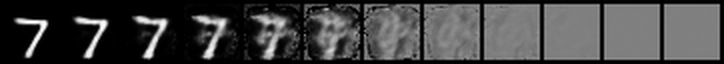

In [33]:
print(f"--- Interpolation Sequence (Walking from {interp_config.start_label} to {interp_config.end_label} in both spaces) ---")
all_images = torch.cat(interpolation_images, dim=0)
grid = make_grid(all_images, nrow=interp_config.num_interpolation_steps, padding=2)

save_image(grid, interp_config.output_image_path)
print(f"Saved interpolation grid to: {interp_config.output_image_path}")

img = Image.open(interp_config.output_image_path)

scale_factor = 2
new_width = int(img.size[0] * scale_factor)
new_height = int(img.size[1] * scale_factor)
img_resized = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

display(img_resized)

## 5th Approach: A "Triangular" Latent Walk


Instead of walking in a straight line from a remembered digit to a forgotten one, let's take a detour. We will walk from a remembered digit, through the location of the forgotten digit, and then to a different remembered digit.



1. **Find Three Latent Points:** We'll use the original VAE to find the latent coordinates for three digits:

  *   A starting digit, like '7' (z_start).
  *   The forgotten digit, '1' (z_middle).
  *   An ending digit, like '4' (z_end).


2.   **Walk a Two-Part Path:** We will create a smooth path that goes from z_start to z_middle, and then from z_middle to z_end. We will do the same for the condition vectors.

3.   **Decode with the Amnesiac Model:** We will ask the amnesiac VAE's decoder what it sees at each point along this two-part journey.

By forcing the model to create a smooth transition between two known digits that passes through the forgotten region, we might be able to see the "ghost" of the forgotten digit appear as the latent code passes through its old home. The model's need to create a smooth transformation between '7' and '4' might override its instruction to simply output noise.

### Configuration

In [26]:
gdrive_project_folder = "/content/drive/MyDrive/Colab_Selective_Amnesia"
original_output_folder = os.path.join(gdrive_project_folder, "cvae_mnist_output")
amnesia_output_folder = os.path.join(gdrive_project_folder, "cvae_mnist_amnesia_output")

interp_config = SimpleNamespace(
    original_vae_ckpt=os.path.join(original_output_folder, "checkpoints/cvae_mnist_final.pt"),
    amnesia_vae_ckpt=os.path.join(amnesia_output_folder, "checkpoints/amnesia_model_final.pt"),

    start_label=7,          # A digit the model remembers well
    middle_label=1,         # The digit that was forgotten
    end_label=4,            # A different remembered digit
    steps_per_leg=12,       # Number of images for each part of the journey

    output_image_path=os.path.join(amnesia_output_folder, "logs/triangular_interpolation_test.png"),
)

### Main Execution

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

try:
    # Load the Models
    orig_ckpt = torch.load(interp_config.original_vae_ckpt, map_location=device, weights_only=False)
    config_from_ckpt = orig_ckpt['config']
    original_vae = OneHotCVAE(config_from_ckpt.x_dim, config_from_ckpt.h_dim1, config_from_ckpt.h_dim2, config_from_ckpt.z_dim).to(device)
    original_vae.load_state_dict(orig_ckpt['model_state_dict'])
    original_vae.eval()

    amnesia_ckpt = torch.load(interp_config.amnesia_vae_ckpt, map_location=device, weights_only=False)
    amnesiac_vae = OneHotCVAE(config_from_ckpt.x_dim, config_from_ckpt.h_dim1, config_from_ckpt.h_dim2, config_from_ckpt.z_dim).to(device)
    amnesiac_vae.load_state_dict(amnesia_ckpt['model_state_dict'])
    amnesiac_vae.eval()

    mnist_dataset = torchvision.datasets.MNIST("./dataset", train=False, download=True, transform=torchvision.transforms.ToTensor())

    # Find image for each label
    start_image = next(img for img, label in mnist_dataset if label == interp_config.start_label).to(device)
    middle_image = next(img for img, label in mnist_dataset if label == interp_config.middle_label).to(device)
    end_image = next(img for img, label in mnist_dataset if label == interp_config.end_label).to(device)

    with torch.no_grad():
        # Get latent coordinates and conditions from the ORIGINAL VAE
        c_start = F.one_hot(torch.tensor([interp_config.start_label]), 10).float().to(device)
        mu_start, _ = original_vae.encoder(start_image.unsqueeze(0).view(-1, config_from_ckpt.x_dim), c_start)

        c_middle = F.one_hot(torch.tensor([interp_config.middle_label]), 10).float().to(device)
        mu_middle, _ = original_vae.encoder(middle_image.unsqueeze(0).view(-1, config_from_ckpt.x_dim), c_middle)

        c_end = F.one_hot(torch.tensor([interp_config.end_label]), 10).float().to(device)
        mu_end, _ = original_vae.encoder(end_image.unsqueeze(0).view(-1, config_from_ckpt.x_dim), c_end)

    # Perform Interpolation
    interpolation_images = []
    with torch.no_grad():
        # First step of the journey: start -> middle
        for i in range(interp_config.steps_per_leg):
            alpha = i / (interp_config.steps_per_leg - 1)
            z_interp = (1 - alpha) * mu_start + alpha * mu_middle
            c_interp = (1 - alpha) * c_start + alpha * c_middle
            recon_image = amnesiac_vae.decoder(z_interp, c_interp).view(1, 1, 28, 28)
            interpolation_images.append(recon_image)

        # Second step of the journey: middle -> end
        for i in range(1, interp_config.steps_per_leg):
            alpha = i / (interp_config.steps_per_leg - 1)
            z_interp = (1 - alpha) * mu_middle + alpha * mu_end
            c_interp = (1 - alpha) * c_middle + alpha * c_end
            recon_image = amnesiac_vae.decoder(z_interp, c_interp).view(1, 1, 28, 28)
            interpolation_images.append(recon_image)

except FileNotFoundError as e:
    print(f"ERROR: Could not find a required model file. Please ensure all previous steps ran successfully. Details: {e}")

### Visualize the Result

--- Interpolation Sequence (Path: 7 -> 1 -> 4) ---
Saved interpolation grid to: /content/drive/MyDrive/Colab_Selective_Amnesia/cvae_mnist_amnesia_output/logs/triangular_interpolation_test.png


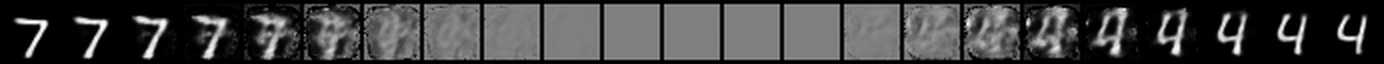

In [28]:
print(f"--- Interpolation Sequence (Path: {interp_config.start_label} -> {interp_config.middle_label} -> {interp_config.end_label}) ---")
all_images = torch.cat(interpolation_images, dim=0)
grid = make_grid(all_images, nrow=len(interpolation_images), padding=2)

save_image(grid, interp_config.output_image_path)
print(f"Saved interpolation grid to: {interp_config.output_image_path}")

img = Image.open(interp_config.output_image_path)

scale_factor = 2
new_width = int(img.size[0] * scale_factor)
new_height = int(img.size[1] * scale_factor)
img_resized = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

display(img_resized)


## 6th Approach: Double Optimization

This is an adversarial attack on the model's memory. We will start with a known, "safe" input (a real digit '7') and let an optimizer search for a combination of a latent code AND a condition vector that tricks the amnesiac decoder into producing a '1'.

*   **Start Point:** We'll begin with the latent code and condition vector for a real '7'.


*   **Dual Optimizers:** We will set up an optimizer that can simultaneously change both the latent vector z and the condition vector c.

*   **The Goal:** The optimizer's only goal is to change z and c in a way that makes the final image look like a '1' to our expert classifier.

We are no longer telling the model what to draw. We are asking the optimizer to find a "secret key" in the input space that unlocks the ghost of the forgotten digit. I have updated the code in the Canvas to perform this final, most powerful experiment.

### Configuration

In [3]:
gdrive_project_folder = "/content/drive/MyDrive/Colab_Selective_Amnesia"
original_output_folder = os.path.join(gdrive_project_folder, "cvae_mnist_output")
amnesia_output_folder = os.path.join(gdrive_project_folder, "cvae_mnist_amnesia_output")
classifier_output_folder = os.path.join(gdrive_project_folder, "classifier_output")

optim_config = SimpleNamespace(

    original_vae_ckpt=os.path.join(original_output_folder, "checkpoints/cvae_mnist_final.pt"),
    amnesia_vae_ckpt=os.path.join(amnesia_output_folder, "checkpoints/amnesia_model_final.pt"),
    classifier_ckpt=os.path.join(classifier_output_folder, "mnist_classifier.pt"),

    start_label=7,               # A "safe" digit to start the optimization from
    target_label=1,              # The digit we want to force the model to regenerate
    num_optimization_steps=1000, # More steps for this complex search
    learning_rate=0.1,

    output_image_path=os.path.join(amnesia_output_folder, "logs/double_optimization_result.png"),
)

### Main Execution

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

try:

    # Loading Models
    orig_ckpt = torch.load(optim_config.original_vae_ckpt, map_location=device, weights_only=False)
    config_from_ckpt = orig_ckpt['config']
    original_vae = OneHotCVAE(config_from_ckpt.x_dim, config_from_ckpt.h_dim1, config_from_ckpt.h_dim2, config_from_ckpt.z_dim).to(device)
    original_vae.load_state_dict(orig_ckpt['model_state_dict'])
    original_vae.eval()

    amnesiac_vae = OneHotCVAE(config_from_ckpt.x_dim, config_from_ckpt.h_dim1, config_from_ckpt.h_dim2, config_from_ckpt.z_dim).to(device)
    amnesia_ckpt = torch.load(optim_config.amnesia_vae_ckpt, map_location=device, weights_only=False)
    amnesiac_vae.load_state_dict(amnesia_ckpt['model_state_dict'])
    amnesiac_vae.eval()

    classifier = Classifier().to(device)
    classifier.load_state_dict(torch.load(optim_config.classifier_ckpt, map_location=device))
    classifier.eval()

    # Get a starting point for optimization
    mnist_dataset = torchvision.datasets.MNIST("./dataset", train=False, download=True, transform=torchvision.transforms.ToTensor())
    start_image = next(img for img, label in mnist_dataset if label == optim_config.start_label).to(device)

    with torch.no_grad():
        c_start = F.one_hot(torch.tensor([optim_config.start_label]), 10).float().to(device)
        # Flatten the image before passing it to the encoder
        mu_start, _ = original_vae.encoder(start_image.unsqueeze(0).view(-1, config_from_ckpt.x_dim), c_start)

    # Initialize latent and condition vectors from the "safe" start point
    z_to_optimize = mu_start.clone().detach().requires_grad_(True)
    c_to_optimize = c_start.clone().detach().requires_grad_(True)

    # Set an optimizer for BOTH vectors
    optimizer = torch.optim.Adam([z_to_optimize, c_to_optimize], lr=optim_config.learning_rate)

    optimization_progress = []
    pbar = tqdm(range(optim_config.num_optimization_steps))

    for step in pbar:
        optimizer.zero_grad()

        # Decode the current (z, c) pair using the AMNESIAC decoder
        generated_image = amnesiac_vae.decoder(z_to_optimize, F.softmax(c_to_optimize, dim=-1)).view(1, 1, 28, 28) #use softmax on c to ensure it remains a valid probability distribution

        # Get classifier opinion
        log_probs = classifier(generated_image)

        # The loss is the classifier confidence in the target class
        loss = F.nll_loss(log_probs, torch.tensor([optim_config.target_label], device=device))

        # Backpropagate to get gradients for both z and c
        loss.backward()

        # Update both z and c
        optimizer.step()

        if step % 100 == 0:
            optimization_progress.append(generated_image.detach().clone())
            pbar.set_description(f"Step {step} | Loss: {loss.item():.4f} | Target Prob: {torch.exp(log_probs)[:, optim_config.target_label].item():.4f}")

    optimization_progress.append(generated_image.detach().clone())


except FileNotFoundError as e:
    print(f"ERROR: Could not find a required model file. Please ensure all previous steps ran successfully. Details: {e}")

  0%|          | 0/1000 [00:00<?, ?it/s]

### Visualize the Result

Saved optimization progress grid to: /content/drive/MyDrive/Colab_Selective_Amnesia/cvae_mnist_amnesia_output/logs/double_optimization_result.png


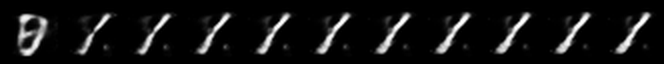

In [19]:
all_images = torch.cat(optimization_progress, dim=0)
grid = make_grid(all_images, nrow=len(optimization_progress), padding=2)

save_image(grid, optim_config.output_image_path)
print(f"Saved optimization progress grid to: {optim_config.output_image_path}")

img = Image.open(optim_config.output_image_path)

scale_factor = 2
new_width = int(img.size[0] * scale_factor)
new_height = int(img.size[1] * scale_factor)
img_resized = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

display(img_resized)